In [11]:
from dataloader import *
from unimodal_baseline import *
from figs import *
import json
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [12]:
def convert_for_json(obj):
    if isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(v) for v in obj]
    elif isinstance(obj, (int, float, str, bool, type(None))):
        return obj
    elif isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensors to lists
    elif isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy arrays to lists
    else:
        return str(obj)  # Fallback for unknown types

dataset = AlzheimerDataset('data')
train_loader, val_loader, test_loader = get_data_loaders('data')
mri_mod = MRIBaseline()
models, mets = [], []

for i in range(9):
    mod, metrics = mri_mod.train_on_specific_slice(train_loader, val_loader, test_loader, i)
    torch.save(mod.state_dict(), f'mrimodeltorch{i}')
    with open(f'mrimetrics{i}.json', 'w') as json_file:
        json.dump(convert_for_json(metrics), json_file, indent=4)
    models.append(mod)
    mets.append(convert_for_json(metrics))


Training model for slice 0...


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)


Unexpected exception formatting exception. Falling back to standard exception


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Traceback (most recent call last):
  File "/Users/lolakovalski/miniconda3/envs/lola/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hh/yxpg46b17j90r85ppgtpn6840000gp/T/ipykernel_47137/2837071095.py", line 21, in <module>
    mod, metrics = mri_mod.train_on_specific_slice(train_loader, val_loader, test_loader, i)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lolakovalski/Desktop/lola/code/ADmulti/unimodal_baseline.py", line 495, in train_on_specific_slice
    'precision_per_class': precision_score(all_labels, all_preds, average=None, zero_division=0),
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lolakovalski/Desktop/lola/code/ADmulti/unimodal_baseline.py", line 337, in _calculate_class_weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
import inspect
# import shap

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision import models
from torchvision.models import vgg16, VGG16_Weights

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score

def sanity_check_alignment(model, dataset, test_loader, slice_idx=4):
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score

    model.eval()
    device = next(model.parameters()).device
    y_pred, y_true, cdrs = [], [], []

    subset_indices = test_loader.dataset.indices
    batch_start = 0

    with torch.no_grad():
        for batch in test_loader:
            batch_size = batch['label'].shape[0]

            # MRI input
            img = batch['mri'][:, 0, slice_idx, :, :].unsqueeze(1).to(model.device)

            # Predict
            outputs = model(img)
            if isinstance(outputs, dict):
                outputs = outputs['logits']
            preds = torch.argmax(outputs, dim=1)

            # Store
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(batch['label'].view(-1).cpu().tolist())

            # Grab CDRs via index alignment
            batch_indices = subset_indices[batch_start:batch_start + batch_size]
            cdrs.extend([dataset.multiclass_labels[i] for i in batch_indices])
            batch_start += batch_size

    y_pred = np.array(y_pred, dtype=int)
    y_true = np.array(y_true, dtype=int)
    cdrs = np.array(cdrs)

    print("=== Sanity Check ===")
    print(f"y_pred.shape: {y_pred.shape}")
    print(f"y_true.shape: {y_true.shape}")
    print(f"Accuracy (np.mean): {np.mean(y_pred == y_true):.4f}")
    print(f"Accuracy (sklearn): {accuracy_score(y_true, y_pred):.4f}")
    print(f"Unique predictions: {np.unique(y_pred, return_counts=True)}")
    print(f"Unique labels: {np.unique(y_true, return_counts=True)}")
    print(f"First 10 preds: {y_pred[:10]}")
    print(f"First 10 labels: {y_true[:10]}")
    print("====================")



def plot_precision_recall_curve_torch(model, filename=None):
    model.eval()
    y_scores = []
    y_true = []
    cdr_list = []

    with torch.no_grad():
        for batch in test_loader:
            # For VGG: use only the middle slice and repeat for 3 channels
            img = batch['mri'][:, 0, 4, :, :].unsqueeze(1)
            outputs = model(img)
            if isinstance(outputs, dict):
                outputs = outputs['logits']
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (AD)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(batch['label'].cpu().numpy())

    y_scores = np.array(y_scores)
    y_true = np.array(y_true).flatten()

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)



    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR Curve (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

In [ ]:
mri_mod.evaluate(mod, val_loader, 6)

NameError: name 'mri_mod' is not defined

In [ ]:
sanity_check_alignment(mri_mod.model, dataset, test_loader)


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)


AttributeError: 'VGG' object has no attribute 'device'

In [ ]:
plot_precision_recall_curve_torch(torch.load("mrimodeltorch6"))

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def plotByCDR_torch(model, test_loader, dataset, slice_idx=6, filename=None):

    model.eval()
    y_pred = []
    y_true = []
    # Get the indices of the test set (for CDR lookup)
    if hasattr(test_loader.dataset, 'indices'):
        test_indices = test_loader.dataset.indices
    else:
        test_indices = np.arange(len(test_loader.dataset))
    test_cdrs = np.array([dataset.multiclass_labels[i] for i in test_indices])

    with torch.no_grad():
        for batch in test_loader:
            img = batch['mri'][:, :, slice_idx, :, :]  # [batch, 1, H, W]
            img = img.to(next(model.parameters()).device)
            outputs = model(img)
            if isinstance(outputs, dict):
                outputs = outputs['logits']
            predictions = torch.argmax(outputs, dim=1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(batch['label'].cpu().numpy())

    y_pred = np.array(y_pred).flatten()
    y_true = np.array(y_true).flatten()
    correct = (y_pred == y_true)
    incorrect = ~correct
    correct_cdrs = test_cdrs[correct]
    incorrect_cdrs = test_cdrs[incorrect]

    # Get all unique CDR values across both sets
    all_cdrs = np.unique(test_cdrs)

    # Count correct and incorrect per CDR
    correct_counts = np.array([np.sum(correct_cdrs == cdr) for cdr in all_cdrs])
    incorrect_counts = np.array([np.sum(incorrect_cdrs == cdr) for cdr in all_cdrs])
    total_counts = correct_counts + incorrect_counts

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    bar1 = ax.bar(all_cdrs, correct_counts, width=0.1, label='Correct', color='green')
    bar2 = ax.bar(all_cdrs, incorrect_counts, width=0.1, bottom=correct_counts, label='Incorrect', color='red')

    # Add percent correct above bars
    for i, (x, c, t) in enumerate(zip(all_cdrs, correct_counts, total_counts)):
        if t > 0:
            percent = 100 * (t-c)/ t
            ax.text(x, c + incorrect_counts[i] + 0.5, f"{percent:.1f}%", ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('CDR Value')
    ax.set_ylabel('Number of Predictions')
    ax.set_title('Prediction Outcomes by CDR')
    ax.legend()
    
    if filename:
        plt.savefig(filename)
    plt.show()

/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)


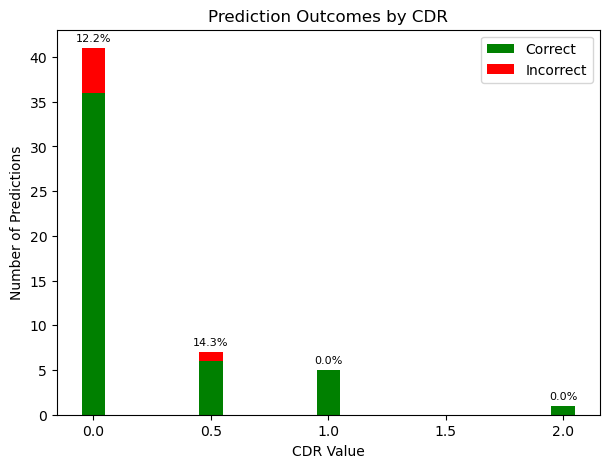

In [ ]:
plotByCDR_torch(mod, test_loader, dataset)

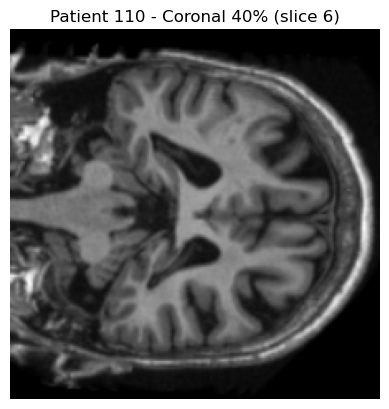

In [ ]:
import matplotlib.pyplot as plt

# Pick a random patient index
import random
idx = random.randint(0, len(dataset) - 1)

# Load the MRI slices for this patient
slices = dataset.load_mri(dataset.mri_paths[idx])  # shape: (1, 9, 224, 224)
slice6 = slices[0, 6, :, :]  # [batch, slice, H, W]

plt.imshow(slice6, cmap='gray')
plt.title(f'Patient {idx} - Coronal 40% (slice 6)')
plt.axis('off')
plt.show()

In [ ]:
cnn_features = []
tabular_features = []
labels = []

# Use penultimate layer as feature extractor -- before binary classifaction layer
feature_extractor = nn.Sequential(*list(mod.children())[:-1])
for batch in train_loader:
    mri = batch['mri'].to(mri_mod.device)
    mri = mri.squeeze(1) if mri.dim() != -1 else mri
    with torch.no_grad():
        feats = feature_extractor(mri)
        feats = feats.view(feats.size(0), -1).cpu().numpy()
    cnn_features.append(feats)
    tabular_features.append(batch['tabular'].cpu().numpy())
    labels.append(batch['label'].view(-1).cpu().numpy())

print(cnn_features)

NameError: name 'nn' is not defined

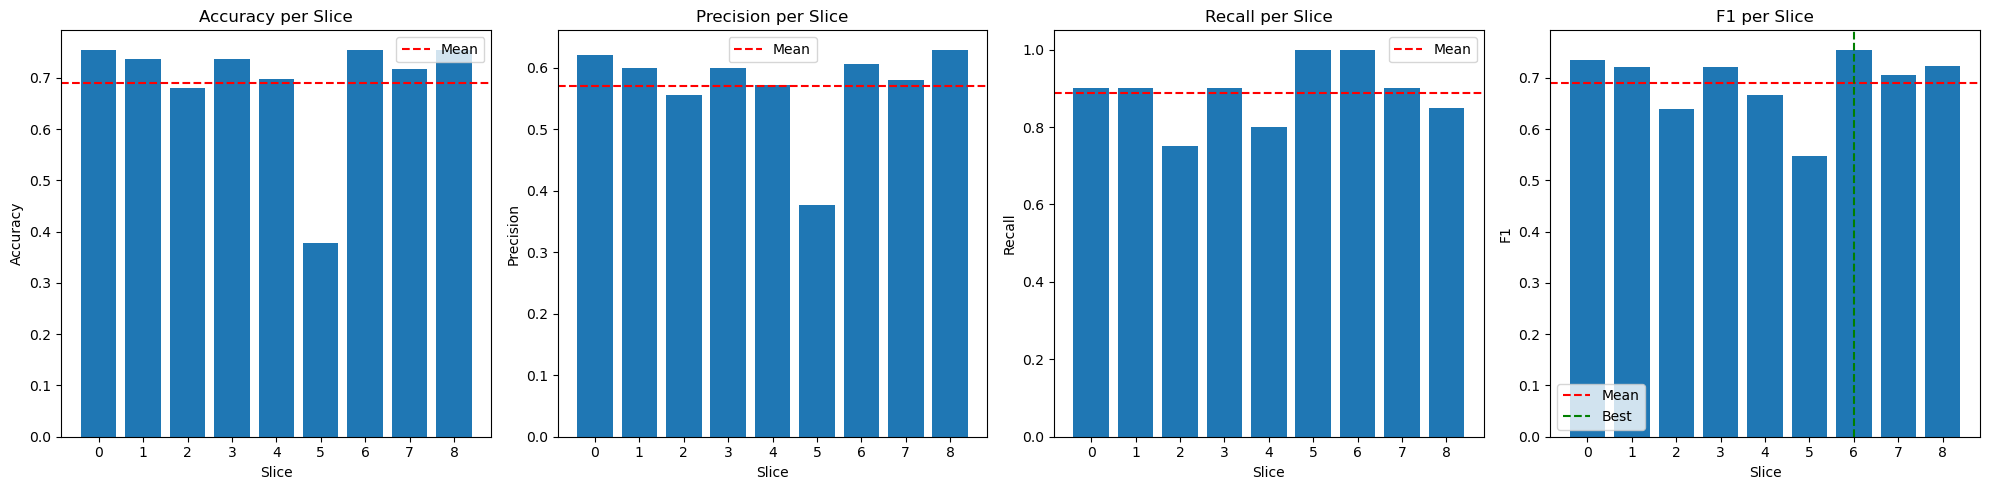

Selected Slice: 6 with F1 Score: 0.755


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt


# Load metrics from all slices
slices = range(9)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for slice_idx in slices:
    json_path = f'mrimetrics{slice_idx}.json'
    with open(json_path, 'r') as f:
        data = json.load(f)
        metrics['accuracy'].append(data['accuracy'])
        metrics['precision'].append(data['precision'])
        metrics['recall'].append(data['recall'])
        metrics['f1'].append(data['f1'])

# Compute means for each metric
means = {k: np.mean(v) for k, v in metrics.items()}
best_slice = np.argmax(metrics['f1'])  # Based on F1

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

metric_names = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy per Slice', 'Precision per Slice', 'Recall per Slice', 'F1 per Slice']
y_labels = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, ax in enumerate(axes):
    metric = metric_names[i]
    ax.bar(slices, metrics[metric])
    ax.axhline(means[metric], color='red', linestyle='--', label='Mean')
    
    # Highlight the best slice based on F1
    if metric == 'f1':
        ax.axvline(best_slice, color='green', linestyle='--', label='Best')

    ax.set_title(titles[i])
    ax.set_xlabel('Slice')
    ax.set_ylabel(y_labels[i])
    ax.set_xticks(slices)
    ax.legend()

plt.tight_layout()
plt.show()

print(f"Selected Slice: {best_slice} with F1 Score: {metrics['f1'][best_slice]:.3f}")


In [ ]:
# Initialize class and load data
mri_model = MRIBaseline()
mri_model.load_data(train_loader, val_loader, test_loader)  # This will now load CDR correctly

# Train the model on slice 6 (index 5)
slice_idx = 6
trained_model, val_metrics = mri_model.train_on_specific_slice(
    train_loader, val_loader, test_loader, slice_idx=slice_idx
)

# Save the full model object correctly
torch.save(trained_model, "mrimodel_slice6_full.pth")

Loading training data:   0%|          | 0/8 [00:00<?, ?it/s]/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Loading test data:   0%|          | 0/2 [00:00<?, ?it/s]/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slic

Training model for slice 6...


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:   0%|          | 0/20 [00:00<?, ?it/s]/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular

  Epoch 1: loss=99.0791, val_f1=0.369


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  10%|█         | 2/20 [03:24

  Epoch 2: loss=98.7133, val_f1=0.369


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  15%|█▌        | 3/20 [05:06

  Epoch 3: loss=98.2259, val_f1=0.407


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  20%|██        | 4/20 [06:48

  Epoch 4: loss=97.6556, val_f1=0.526


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  25%|██▌       | 5/20 [08:30

  Epoch 5: loss=97.1071, val_f1=0.514


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  30%|███       | 6/20 [10:13

  Epoch 6: loss=96.6709, val_f1=0.588


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  35%|███▌      | 7/20 [11:55

  Epoch 7: loss=96.2067, val_f1=0.615


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  40%|████      | 8/20 [13:38

  Epoch 8: loss=95.7495, val_f1=0.625


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  45%|████▌     | 9/20 [15:20

  Epoch 9: loss=95.2846, val_f1=0.606


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  50%|█████     | 10/20 [17:0

  Epoch 10: loss=94.7295, val_f1=0.588


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  55%|█████▌    | 11/20 [18:4

  Epoch 11: loss=94.1531, val_f1=0.588


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  60%|██████    | 12/20 [20:2

  Epoch 12: loss=93.7544, val_f1=0.519


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  65%|██████▌   | 13/20 [22:1

  Epoch 13: loss=93.6694, val_f1=0.600


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  70%|███████   | 14/20 [23:5

  Epoch 14: loss=93.5759, val_f1=0.600


/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Training with early stopping:  70%|███████   | 14/20 [25:3

  Epoch 15: loss=93.5155, val_f1=0.600
  Early stopping triggered


In [ ]:
mri_model = MRIBaseline()
mri_model.load_data(train_loader, val_loader, test_loader)  # This will now load CDR correctly

# Load the entire model object
loaded_model = torch.load("mrimodel_slice6_full.pth", weights_only = False)
loaded_model.to(mri_model.device)
loaded_model.eval()

slice_idx = 6

# Evaluate on Validation Set
val_metrics = mri_model.evaluate(loaded_model, val_loader, slice_idx=slice_idx)

# Evaluate on Test Set
test_metrics = mri_model.evaluate(loaded_model, test_loader, slice_idx=slice_idx)

Loading training data:   0%|          | 0/8 [00:00<?, ?it/s]/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
Loading validation data:   0%|          | 0/2 [00:00<?, ?it/s]/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empty slice
  self._feature_means = np.nanmean(all_tabular, axis=0)
/Users/lolakovalski/Desktop/lola/code/ADmulti/dataloader.py:178: RuntimeWarning: Mean of empt

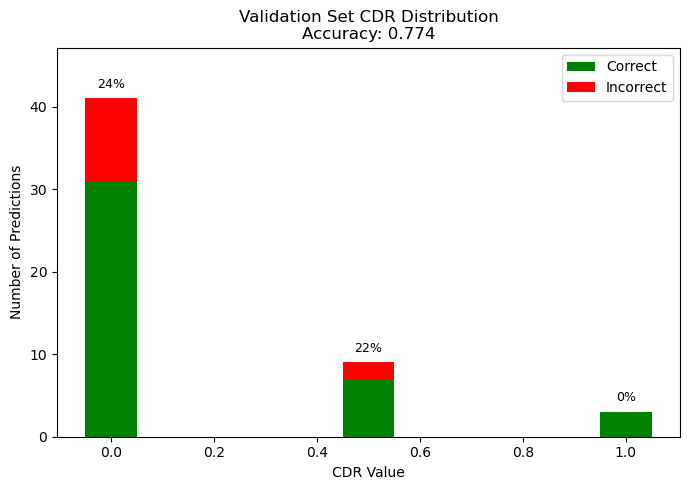

Validation Set CDR Distribution Metrics:
Accuracy : 0.774
Precision: 0.500
Recall   : 0.833
F1 Score : 0.625


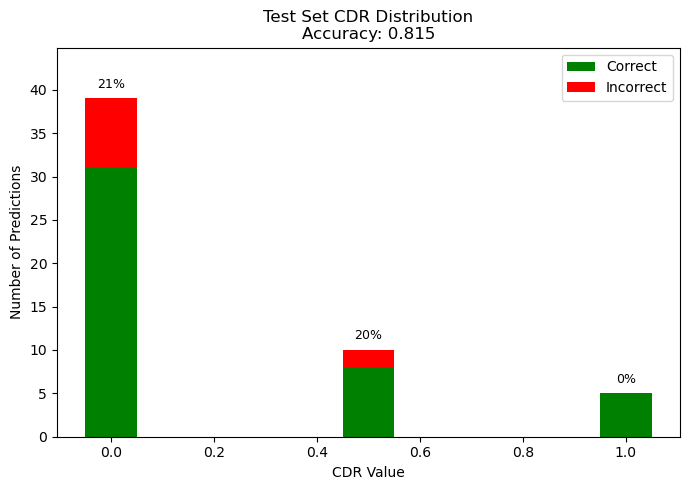

Test Set CDR Distribution Metrics:
Accuracy : 0.815
Precision: 0.619
Recall   : 0.867
F1 Score : 0.722


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the full dataset object to access multiclass labels directly
dataset = AlzheimerDataset('data')  # Replace 'data' with your actual path

# Access the multiclass CDR labels directly from the dataset split indices
val_cdr_labels = [dataset.multiclass_labels[i] for i in val_loader.dataset.indices]
test_cdr_labels = [dataset.multiclass_labels[i] for i in test_loader.dataset.indices]


def evaluate_and_plot(model, data_batches, true_labels, cdr_labels, slice_idx, title, device):
    model.eval()
    all_preds, all_true = [], []
    
    with torch.no_grad():
        for batch in data_batches:
            mri_slices = batch['mri'][:, :, slice_idx, :, :].to(device)
            labels = batch['label'].to(device).long().view(-1)
            
            outputs = model(mri_slices)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().tolist())
            all_true.extend(labels.cpu().tolist())
    
    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    cdr_labels = np.array(cdr_labels)

    correct = (all_preds == all_true)
    incorrect = ~correct

    all_cdrs = np.unique(cdr_labels)
    correct_counts = np.array([np.sum(correct[cdr_labels == cdr]) for cdr in all_cdrs])
    incorrect_counts = np.array([np.sum(incorrect[cdr_labels == cdr]) for cdr in all_cdrs])
    total_counts = correct_counts + incorrect_counts
    percent_incorrect = np.divide(
        incorrect_counts, total_counts, 
        out=np.zeros_like(incorrect_counts, dtype=float), 
        where=total_counts != 0
    )
    
    acc = accuracy_score(all_true, all_preds)
    prec = precision_score(all_true, all_preds, zero_division=0)
    rec = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)

    plt.figure(figsize=(7, 5))
    plt.bar(all_cdrs, correct_counts, width=0.1, label='Correct', color='green')
    plt.bar(all_cdrs, incorrect_counts, width=0.1, bottom=correct_counts, label='Incorrect', color='red')
    
    ymax = max(total_counts) * 1.15
    plt.ylim(0, ymax)
    
    for j, (cdr, total, pct) in enumerate(zip(all_cdrs, total_counts, percent_incorrect)):
        plt.text(cdr, total + ymax * 0.02, f'{100 * pct:.0f}%', ha='center', va='bottom', fontsize=9)

    # Include Accuracy in Title
    plt.xlabel('CDR Value')
    plt.ylabel('Number of Predictions')
    plt.title(f"{title}\nAccuracy: {acc:.3f}", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"{title} Metrics:")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print("=" * 40)

slice_idx = 6
device = mri_model.device

# Validation Plot
evaluate_and_plot(
    loaded_model, 
    mri_model.val_data, 
    mri_model.y_val, 
    val_cdr_labels,  # Use precomputed CDR labels
    slice_idx, 
    "Validation Set CDR Distribution", 
    device
)

# Test Plot
evaluate_and_plot(
    loaded_model, 
    mri_model.test_data, 
    mri_model.y_test, 
    test_cdr_labels,  # Use precomputed CDR labels
    slice_idx, 
    "Test Set CDR Distribution", 
    device
)


In [ ]:
def plot_precision_recall_curve(model, data_batches, true_labels, slice_idx, title, device):
    model.eval()
    all_probs, all_true = [], []

    with torch.no_grad():
        for batch in data_batches:
            mri_slices = batch['mri'][:, :, slice_idx, :, :].to(device)
            labels = batch['label'].to(device).long().view(-1)

            outputs = model(mri_slices)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1 (positive class)

            all_probs.extend(probs.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_true = np.array(all_true)

    precision, recall, _ = precision_recall_curve(all_true, all_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    epochs = [h['epoch'] for h in history]
    loss = [h['loss'] for h in history]
    acc = [h['accuracy'] for h in history]
    f1 = [h['f1'] for h in history]

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, loss, label='Loss')
    plt.plot(epochs, acc, label='Accuracy')
    plt.plot(epochs, f1, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


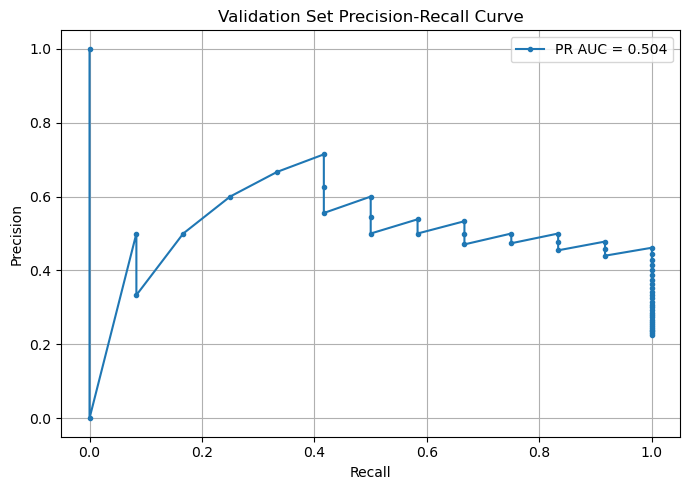

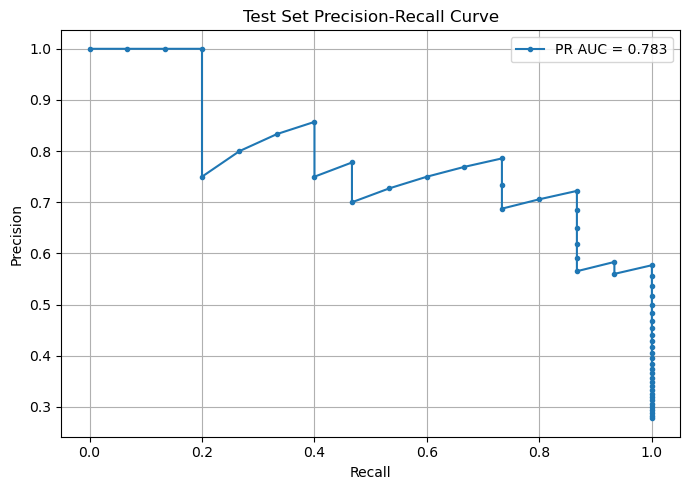

NameError: name 'training_history' is not defined

In [ ]:
slice_idx = 6
device = mri_model.device

# Precision-Recall Curve for Validation Set
plot_precision_recall_curve(
    loaded_model,
    mri_model.val_data,
    mri_model.y_val,
    slice_idx,
    "Validation Set",
    device
)

# Precision-Recall Curve for Test Set
plot_precision_recall_curve(
    loaded_model,
    mri_model.test_data,
    mri_model.y_test,
    slice_idx,
    "Test Set",
    device
)

# Plot Training History (assuming you saved history while training)
plot_training_history(training_history)
